##### Import Libraries

In [1]:
# ShoW each Cell's Execution Time
# %pip install -q bitsandbytes  boto3
# %pip install --upgrade -q torch torchvision

# %pip install -q --upgrade transformers datasets python-dotenv
# %pip install -q --upgrade ipython-autotime bitsandbytes

In [2]:
%load_ext autotime

time: 64.4 μs (started: 2024-11-01 09:04:59 +00:00)


In [3]:
GPU_nb = 0

In [4]:
import torch

if torch.cuda.is_available():
    DEVICE = torch.device(f'cuda:{GPU_nb}')
    print(f" DEVICE: {DEVICE}. GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    DEVICE = 'cpu'
    print(f" DEVICE: {DEVICE}. No GPU available. Training will run on CPU.")

 DEVICE: cuda:0. GPU: NVIDIA A100-SXM4-80GB is available.
time: 6.35 s (started: 2024-11-01 09:04:59 +00:00)


In [5]:
notebook_cache_dir = "/dev/shm/tmpfs"

time: 403 μs (started: 2024-11-01 09:05:06 +00:00)


In [6]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
# import time
# import re
import os
# import seaborn as sns
# from functools import partial
import boto3
import datetime
from utils import *
# import random
import sys
#######################################################################################################################
# import numpy as np
# import torch
# import torch.nn as nn
from torch.optim import AdamW
# import torch.nn.functional as F
#######################################################################################################################
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler
from datasets import load_dataset
from torch.utils.data import Subset, Dataset
from torch.nn.utils.rnn import pad_sequence

from torch.cuda.amp import GradScaler, autocast
# from torch.amp import GradScaler, autocast
#######################################################################################################################
import warnings
import logging
# import sys
# import json
from dotenv import load_dotenv

time: 1.64 s (started: 2024-11-01 09:05:06 +00:00)


In [7]:
Llama32_1B_MAX_LENGTH = 8192
BATCH_SIZE = 1
EPOCHS = 5
LR_TRAIN = 5e-5

time: 344 μs (started: 2024-11-01 09:05:07 +00:00)


In [8]:
sys.path.append('./src')  # link to GTL libraries
import src.guided_transfer_learning as gtl

time: 18.3 ms (started: 2024-11-01 09:05:07 +00:00)


In [10]:
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disable tokenizers parallelism to avoid warning

plt.style.use('dark_background')

time: 1.13 ms (started: 2024-11-01 09:05:07 +00:00)


##### Llama-3.2 1B from Hugging Face bfp-16:

In [11]:
# Load the tokenizer and model
model_name = "meta-llama/Llama-3.2-1B"
llama32_1B_tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN, cache_dir=notebook_cache_dir)
llama32_1B_tokenizer.pad_token = llama32_1B_tokenizer.eos_token
llama32_1B_tokenizer.padding_side = 'right'

time: 460 ms (started: 2024-11-01 09:05:07 +00:00)


In [12]:
# llama32_1B_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, token=HF_TOKEN)
llama32_1B_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN,
    cache_dir=notebook_cache_dir
    ).to(DEVICE)

time: 4.17 s (started: 2024-11-01 09:05:08 +00:00)


In [13]:
# Unfreeze model layers:
for param in llama32_1B_model.parameters():
    if param.dtype in [torch.float32, torch.float64, torch.float16, torch.bfloat16]:
        param.requires_grad = True
    else:
        param.requires_grad = False

time: 1.12 ms (started: 2024-11-01 09:05:12 +00:00)


In [14]:
# check_trainable_layers(llama32_1B_model)

time: 403 μs (started: 2024-11-01 09:05:12 +00:00)


##### The pile dataset

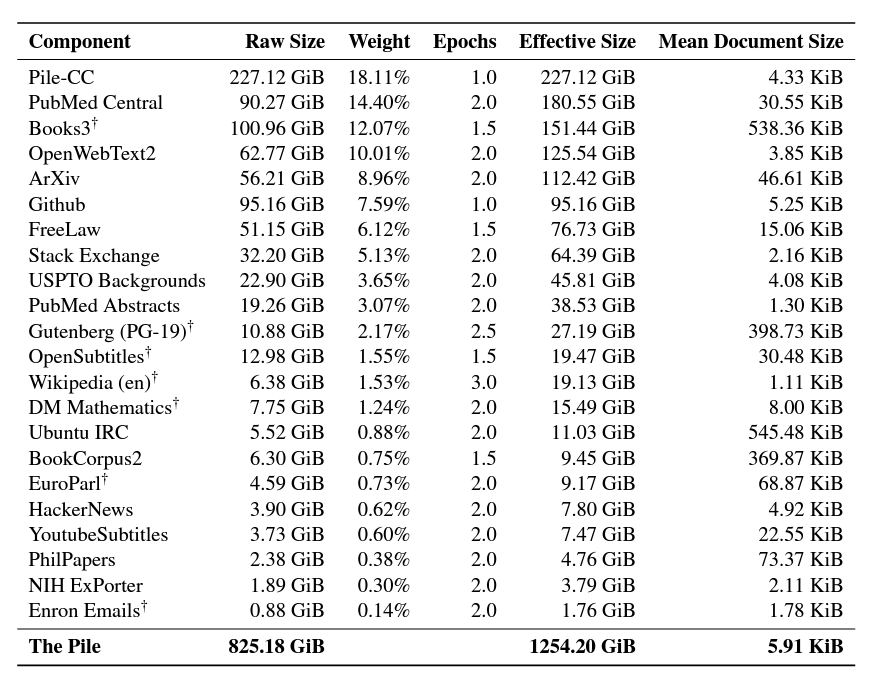

https://arxiv.org/abs/2101.00027

In [15]:
from datasets import get_dataset_config_names

dataset_name = "EleutherAI/pile"
thepile_subsets = get_dataset_config_names(dataset_name, trust_remote_code=True)
print(thepile_subsets)

['all', 'enron_emails', 'europarl', 'free_law', 'hacker_news', 'nih_exporter', 'pubmed', 'pubmed_central', 'ubuntu_irc', 'uspto', 'github']
time: 193 ms (started: 2024-11-01 09:05:12 +00:00)


In [16]:
thepile_subsets_links = [
    'jacquelinehe/enron-emails',               # 972 MB     :   0 rows                  ['text']   0
    'haritzpuerto/the_pile_00_OpenWebText2',   # 2.78 GB    :   1,146,125 rows          ['text']   1
    'haritzpuerto/the_pile_00_FreeLaw',        # 1.47 GB    :   179,280 rows            ['text']   2
    'amongglue/youtube_subtitles',             # 1.96 GB    :   710,197 rows            ['text']   3
    'haritzpuerto/the_pile_00_Github',         # 1.29 GB    :   638,663 rows            ['text']   4
    'somewheresystems/dataclysm-wikipedia',    # 2.23 GB    :   620,000 rows            ['text']   5
    'recursal/Europarl-Conversation',          # 4.93 GB    :   187,071 rows            ['text']   6
    'haritzpuerto/the_pile_00_PubMed_Central', # 3.00 GB    :   201,734 rows            ['text']   7
]


time: 517 μs (started: 2024-11-01 09:05:12 +00:00)


In [17]:
dataset_name = thepile_subsets_links[GPU_nb]
# dataset_name = "NeelNanda/pile-10k"

dataset = load_dataset(dataset_name, split={'train': 'train[:85%]', 'validation': 'train[85%:]'}, cache_dir=notebook_cache_dir)

time: 512 ms (started: 2024-11-01 09:05:12 +00:00)


In [18]:
print(f"Total number of texts in the train dataset: {len(dataset['train'])}")
print(f"Total number of texts in the validation dataset: {len(dataset['validation'])}")


Total number of texts in the train dataset: 787212
Total number of texts in the validation dataset: 138920
time: 436 μs (started: 2024-11-01 09:05:13 +00:00)


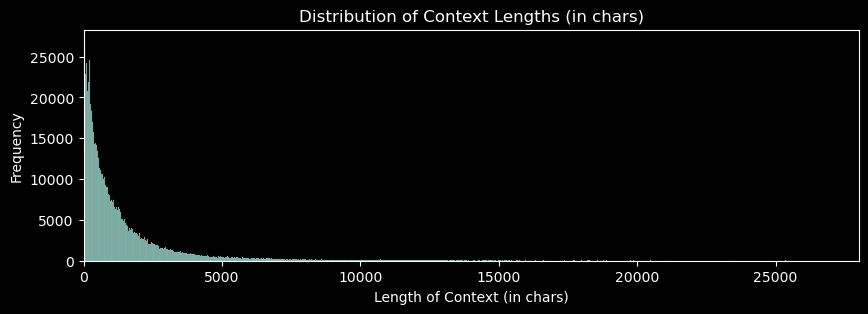

time: 1min 7s (started: 2024-11-01 09:05:13 +00:00)


In [19]:
temp_dataset_train = dataset['train'].filter(lambda example: example["text"] is not None)
temp_dataset_train = temp_dataset_train.add_column("Context_length", [len(text) for text in temp_dataset_train["text"]])

title = 'Distribution of Context Lengths (in chars)'
xlabel_title = 'Length of Context (in chars)'
ylabel_title = 'Frequency'
xlim = 28000

plot_textDataset_distribution(temp_dataset_train, title, xlabel_title, ylabel_title, xlim)

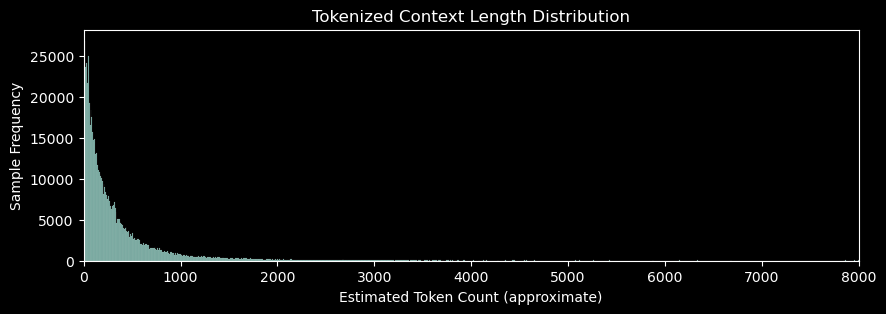

time: 1min 10s (started: 2024-11-01 09:06:20 +00:00)


In [20]:
temp_dataset_train = dataset['train'].filter(lambda example: example["text"] is not None)
temp_dataset_train = temp_dataset_train.add_column("Context_length", [len(text)//4 for text in temp_dataset_train["text"]])

title = 'Tokenized Context Length Distribution'
xlabel_title = 'Estimated Token Count (approximate)'
ylabel_title = 'Sample Frequency'
xlim = 8000
plot_textDataset_distribution(temp_dataset_train, title, xlabel_title, ylabel_title, xlim)

In [21]:
del temp_dataset_train

time: 3.69 ms (started: 2024-11-01 09:07:30 +00:00)


In [22]:
CHARACTER_LIMIT = 4000

time: 1.76 ms (started: 2024-11-01 09:07:30 +00:00)


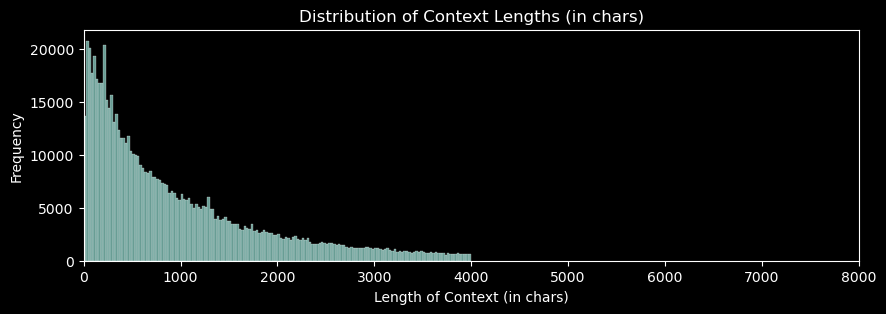

time: 7.78 s (started: 2024-11-01 09:07:30 +00:00)


In [23]:
temp_dataset_train = dataset['train'].filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
temp_dataset_train = temp_dataset_train.add_column("Context_length", [len(text) for text in temp_dataset_train["text"]])

title = 'Distribution of Context Lengths (in chars)'
xlabel_title = 'Length of Context (in chars)'
ylabel_title = 'Frequency'
xlim = 8000

plot_textDataset_distribution(temp_dataset_train, title, xlabel_title, ylabel_title, xlim)

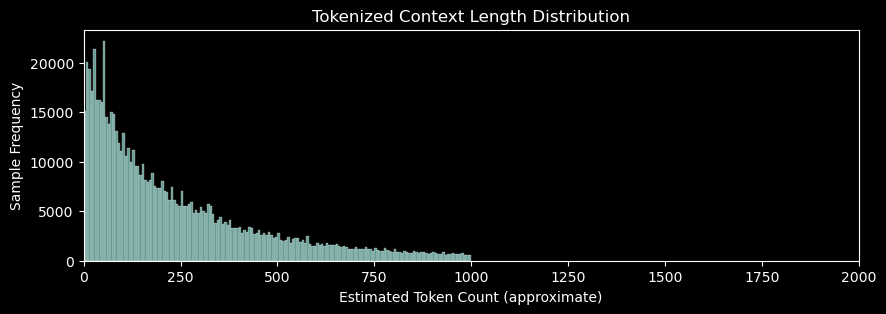

time: 10.7 s (started: 2024-11-01 09:07:38 +00:00)


In [24]:
temp_dataset_train = dataset['train'].filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
temp_dataset_train = temp_dataset_train.add_column("Context_length", [len(text)//4 for text in temp_dataset_train["text"]])

title = 'Tokenized Context Length Distribution'
xlabel_title = 'Estimated Token Count (approximate)'
ylabel_title = 'Sample Frequency'
xlim = 2000

plot_textDataset_distribution(temp_dataset_train, title, xlabel_title, ylabel_title, xlim)

- Filtering Long texts:

In [25]:
# train_subset = dataset['train']
# val_subset = dataset['validation']

FILTER_LONG_TEXTS = True
TAKE_PERCENTAGE = True
TRAIN_SAMPLES = int(len(dataset['train']) * 0.5)
VAL_SAMPLES = int(len(dataset['validation']) * 0.5)

if FILTER_LONG_TEXTS:
    if TAKE_PERCENTAGE:
        train_subset = dataset['train'].shuffle(seed=12345).select(range(TRAIN_SAMPLES)).filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
        val_subset = dataset['validation'].shuffle(seed=12345).select(range(VAL_SAMPLES)).filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
    else:
        train_subset = dataset['train'].filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
        val_subset = dataset['validation'].filter(lambda example: example["text"] is not None and len(example["text"]) <= CHARACTER_LIMIT)
    BATCH_SIZE = 8000 // (CHARACTER_LIMIT//3)  # 8k is max context length
else:
    if TAKE_PERCENTAGE:
        train_subset = dataset['train'].shuffle(seed=12345).select(range(TRAIN_SAMPLES)).filter(lambda example: example["text"] is not None )
        val_subset = dataset['validation'].shuffle(seed=12345).select(range(VAL_SAMPLES)).filter(lambda example: example["text"] is not None)
    else:
        train_subset = dataset['train'].filter(lambda example: example["text"] is not None)
        val_subset = dataset['validation'].filter(lambda example: example["text"] is not None)
    BATCH_SIZE = 1

print(f"Number of samples in train_subset: {len(train_subset)}")
print(f"Number of samples in val_subset: {len(val_subset)}")
print(f"CHARACTER_LIMIT: {CHARACTER_LIMIT}")
print(f"BATCH SIZE: {BATCH_SIZE}")

Number of samples in train_subset: 359426
Number of samples in val_subset: 63381
CHARACTER_LIMIT: 4000
BATCH SIZE: 6
time: 22.2 ms (started: 2024-11-01 09:07:48 +00:00)


In [26]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    input_ids_padded = pad_sequence(input_ids,batch_first=True,padding_value=llama32_1B_tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks,batch_first=True,padding_value=0)
    return {'input_ids': input_ids_padded, 'attention_mask': attention_masks_padded}

time: 528 μs (started: 2024-11-01 09:07:48 +00:00)


In [27]:
TOKENIZE_ALL_DATASET_ON_LOAD = False

if TOKENIZE_ALL_DATASET_ON_LOAD:
    print("Creating Custom Dataset (tokenization on loading)...")
    train_dataset = CustomDataset_tokenize_onLoad(train_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    # train_dataset = CustomDataset(train_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4,pin_memory=True)
    #######################################################################################

    val_dataset = CustomDataset_tokenize_onLoad(val_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    # val_dataset = CustomDataset(val_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4, pin_memory=True)
    print("Custom Dataset and DataLoaders created.")
else:
    print("Creating Custom Dataset...")
    # train_dataset = CustomDataset_tokenize_onLoad(train_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    train_dataset = CustomDataset(train_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4,pin_memory=True)
    #######################################################################################

    # val_dataset = CustomDataset_tokenize_onLoad(val_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    val_dataset = CustomDataset(val_subset['text'],tokenizer=llama32_1B_tokenizer,max_length=Llama32_1B_MAX_LENGTH)
    val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn,num_workers=4, pin_memory=True)
    print("Custom Dataset and DataLoaders created.")

Creating Custom Dataset...
Custom Dataset and DataLoaders created.
time: 2.62 s (started: 2024-11-01 09:07:48 +00:00)


In [ ]:
s3 = boto3.client('s3')
bucket_name = 'gtl-bucket-nvirginia'


In [ ]:
ADAMW_OPTIMIZER = AdamW(llama32_1B_model.parameters(), lr=LR_TRAIN)
print("Training...")
llama32_1B_losses = train_model(
    llama32_1B_model,
    optimizer=ADAMW_OPTIMIZER,
    device=DEVICE,
    epochs=EPOCHS,
    train_loader=train_loader,
    validation_loader=val_loader,
    patience=2,  # Early stopping patience
    train_verbose=True,
    eval_verbose=True,
    with_autocast=False,  # Enable mixed precision if needed
    with_early_stopping=False,  # Enable early stopping
    with_lr_sceduler=False,  # Enable learning rate scheduling
    time_to_sleep=5  # Add delay between epochs (optional)
)
print("Training Finished.")

Training...
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: 

100%|██████████| 10564/10564 [13:06<00:00, 13.43it/s]


# Validation loss: 6.59 
# Epoch: 1 (Learning rate: 5e-05) 

100%|██████████| 10564/10564 [13:08<00:00, 13.39it/s]


 Training loss: 0.70 || Validation loss: 0.60
# Epoch: 2 (Learning rate: 5e-05) 

 25%|██▍       | 14715/59905 [1:02:30<2:45:02,  4.56it/s]

In [ ]:
# 22 hours

In [5]:
# print(llama32_1B_losses)

In [ ]:
# Time to train 1000 samples for 5 epochs is:

In [ ]:
print(llama32_1B_losses)

In [ ]:
plot_results(llama32_1B_losses)

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_saving_name = "Llama3.2-1B-Scout-"+dataset_name.replace('/', '-')+'-'+timestamp+'_model.pth'

model_saving_name = (
    f"Llama3.2-1B-Scout-"
    f"DATASET-{dataset_name.replace('/', '-')}-"
    f"TIME-{timestamp}_"
    f"MAXLEN-{Llama32_1B_MAX_LENGTH}_"
    f"TRAIN_SAMPLES-{TRAIN_SAMPLES}_"
    f"BATCH-{BATCH_SIZE}_"
    f"EPOCHS-{EPOCHS}_"
    f"LR-{LR_TRAIN}_model.pth"
)


In [ ]:
current_folder = os.getcwd()
if not os.path.isdir(os.path.join(current_folder, 'results')):
    os.makedirs(os.path.join(current_folder, 'results'))
saving_folder = os.path.join(current_folder, 'results')

- Save Model Locally

In [ ]:
model_file_path = os.path.join(saving_folder, model_saving_name)
print(f"Saving Model at: {model_file_path}")
torch.save(llama32_1B_model.state_dict(), model_file_path)
print(f"Model saved successfully at: {model_file_path}")

- Save Model in S3

In [ ]:
model_file_path = os.path.join(saving_folder, model_saving_name)
bucket_name = 'gtl-bucket-nvirginia'
s3_file_path = os.path.join('Llama32_1B', model_saving_name)

print("Saving the model to S3...")
upload_to_s3(model_file_path, bucket_name, s3_file_path)
# upload_to_s3(local_file_path, bucket_name, s3_file_path)

print(f"Model saved successfully in S3 at: {s3_file_path}")

In [ ]:
s3_client = boto3.client('s3')
response = s3_client.list_objects_v2(Bucket=bucket_name)
for obj in response.get('Contents', []):
    print(obj['Key'])
